In [1]:
import pandas as pd
import numpy as np
from toolz.curried import *
import patsy
from itertools import product
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from toolz.curried import *

In [3]:
def make_confounded_data(N):

    def get_severity(df):
        return ((np.random.beta(1, 3, size=df.shape[0]) * (df["age"] < 30)) +
                (np.random.beta(3, 1.5, size=df.shape[0]) * (df["age"] >= 30)))

    def get_treatment(df):
        return (.33 * df["sex"] +
                1.5 * df["severity"] +  df["severity"] ** 2 +
                0.15 * np.random.normal(size=df.shape[0]))

    def get_recovery(df):
        return (2 +
                0.5 * df["sex"] +
                0.03 * df["age"] + 0.03 * ((df["age"] * 0.1) ** 2) +
                df["severity"] + np.log(df["severity"]) +
                df["sex"] * df["severity"] -
                df["medication"])

    np.random.seed(1111)
    sexes = np.random.randint(0, 2, size=N)
    ages = np.random.gamma(8, scale=4, size=N)
    meds = np.random.beta(1, 1, size=N)

    # dados com designação aleatória
    df_rnd = pd.DataFrame(dict(sex=sexes, age=ages, medication=meds))
    df_rnd['severity'] = get_severity(df_rnd)
    df_rnd['recovery'] = get_recovery(df_rnd)

    features = ['sex', 'age', 'severity', 'medication', 'recovery']
    df_rnd = df_rnd[features]  # to enforce column order

    # dados observacionais
    df_obs = df_rnd.copy()
    df_obs['medication'] = get_treatment(df_obs)
    df_obs['recovery'] = get_recovery(df_obs)

    # dados contrafactuais data
    df_ctf = df_obs.copy()
    df_ctf['medication'] = ((df_ctf['medication'] == 1) ^ 1).astype(float)
    df_ctf['recovery'] = get_recovery(df_ctf)

    return df_rnd, df_obs, df_ctf

In [4]:
df_rnd, df_obs, df_ctf = make_confounded_data(10000)
_, test_obs, _ = make_confounded_data(10000)

In [5]:
df_obs.head()

,sex,age,severity,medication,recovery
0,0,35.857725,0.803739,1.842994,2.203728
1,1,26.162705,0.146388,0.621524,1.239984
2,1,25.284784,0.141124,0.942649,0.831819
3,1,41.616736,0.402925,1.258135,2.906798
4,0,22.062427,0.139728,0.153666,0.825900


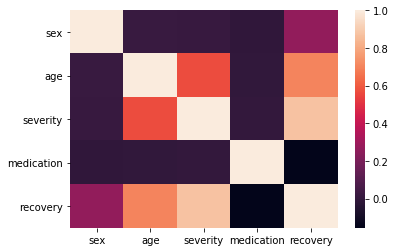

In [6]:
sns.heatmap(df_rnd.corr())
plt.show()

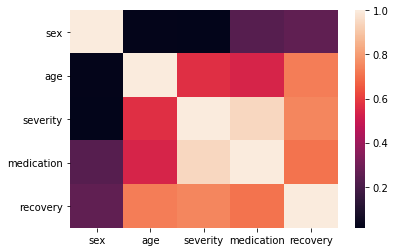

In [7]:
sns.heatmap(df_obs.corr())
plt.show()


## Linear Regression

In [8]:
import statsmodels.formula.api as smf

In [9]:
forumla = "recovery ~ sex + age + severity + medication"
forumla

'recovery ~ sex + age + severity + medication'

In [10]:
model = smf.ols(forumla, data=df_obs).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               recovery   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                 1.211e+04
Date:                Wed, 05 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:22:15   Log-Likelihood:                -7986.4
No. Observations:               10000   AIC:                         1.598e+04
Df Residuals:                    9995   BIC:                         1.602e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3349      0.018    -75.306      0.000      -1.370      -1.300
sex            1.2991      0.015     85.216      0.000       1.269       1.329
age            0.0514      0.001     87.000      0.000       0.050       0.053
severity       7.2146      0.083     86.812      0.000       7.052       7.377
medication    -2.0233      0.032    -62.274      0.000      -2.087      -1.960
==============================================================================
Omnibus:                     7256.477   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183513.117
Skew:                          -3.212   Prob(JB):                         0.00
Kurtosis:                      22.979   Cond. No.                         565.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
a = model.summary()

In [12]:
print(a.as_html())

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>        <td>recovery</td>     <th>  R-squared:         </th> <td>   0.829</td> 
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.829</td> 
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>1.211e+04</td>
</tr>
<tr>
  <th>Date:</th>             <td>Wed, 05 Jun 2019</td> <th>  Prob (F-statistic):</th>  <td>  0.00</td>  
</tr>
<tr>
  <th>Time:</th>                 <td>22:22:15</td>     <th>  Log-Likelihood:    </th> <td> -7986.4</td> 
</tr>
<tr>
  <th>No. Observations:</th>      <td> 10000</td>      <th>  AIC:               </th> <td>1.598e+04</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>  9995</td>      <th>  BIC:               </th> <td>1.602e+04</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     4</td>      <th>                     </th>     <td> </td>    
</tr>
<t

## Naive ML

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
np.random.seed(42)

In [14]:
X = df_obs.drop("recovery", axis=1)
y = df_obs["recovery"]

In [15]:
model = RandomForestRegressor(max_depth=6, n_estimators=100, n_jobs=-1)
print(cross_val_score(model, X, y, cv=5))

[0.98021918 0.9791305  0.98123157 0.9780086  0.97888076]


In [16]:
np.random.seed(42)
model.fit(X, y)
med_level = np.arange(0, 4, 0.1)
y_hats = [model.predict(X.assign(medication = med)).mean() for med in med_level]

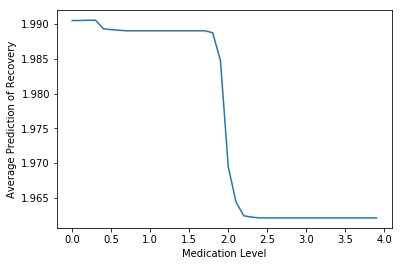

In [17]:
plt.plot(med_level, y_hats)
plt.xlabel("Medication Level")
plt.ylabel("Average Prediction of Recovery")
plt.show()

## Double ML

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [19]:
X = df_obs.drop(columns=["recovery", "medication"]).values
Y = df_obs["recovery"].values
D = df_obs["medication"].values

In [20]:
np.random.seed(42)
Lhat = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1).fit(X, Y).predict(X)
Mhat = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1).fit(X, D).predict(X)

theta = np.dot((D - Mhat), (Y - Lhat)) / np.dot(D - Mhat, D - Mhat)

print("Causal Effect:", theta)

Causal Effect: -0.960112878822859


In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit((D - Mhat).reshape(-1,1), Y - Lhat)

print(model.coef_)

[-0.96011223]


## With Sample Splitting

In [22]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

thetas = []

np.random.seed(42)
for train, test in kf.split(X):
    
    Ghat = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1).fit(X[train],Y[train]).predict(X[test])
    Mhat = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1).fit(X[train],D[train]).predict(X[test])
    
    Vhat = D[test] - Mhat
    Uhat = Y[test] - Ghat
    
    thetas += [np.mean(np.dot(Vhat,Uhat))/np.mean(np.dot(Vhat,Vhat))]


In [23]:
print("Causal Effect:", np.mean(thetas))

Causal Effect: -0.9794459105274222


(array([1., 0., 0., 1., 0., 1., 1., 1.]),
 array([-1.02696507, -1.016733  , -1.00650092, -0.99626885, -0.98603678,
        -0.9758047 , -0.96557263, -0.95534056, -0.94510849]),
 <a list of 8 Patch objects>)

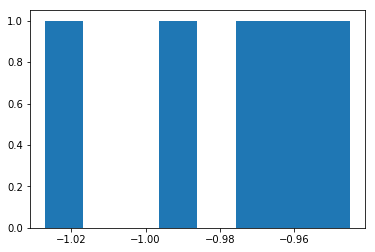

In [24]:
plt.hist(thetas, bins=8)